In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
with open('CleanList.pickle','rb') as read_file:
    df_clean = pickle.load(read_file)

The models show there's strong strong multicollinearity between variables. In this notebook, I'm trying to reduce feature set and see if it can reduce the multicollinearity problem.

# Drop Life Stage

In [2]:
df = df_clean.copy()
del df['Brand']
del df['ItemNumber']

del df['Adult']
del df['PuppyOrKitten']
del df['Senior']

df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['RecommendationScore', 'ReviewNum', 'Price', 'Protein_min', 'Fat_min',
       'Moisture_max', 'Fiber_max', 'Pet', 'Weight', 'PricePerPound', 'Treats',
       'DryFood', 'WetFood', 'FreezeDried', 'FoodTopping', 'Dehydrated',
       'AirDried', 'Frozen', 'BrandGroup_BrandGroup2',
       'BrandGroup_BrandGroup3', 'BrandGroup_BrandGroup4'],
      dtype='object')

In [3]:
df.head(20)

,RecommendationScore,ReviewNum,Price,Protein_min,Fat_min,Moisture_max,Fiber_max,Pet,Weight,PricePerPound,...,DryFood,WetFood,FreezeDried,FoodTopping,Dehydrated,AirDried,Frozen,BrandGroup_BrandGroup2,BrandGroup_BrandGroup3,BrandGroup_BrandGroup4
0,94.0,2676,42.99,32.0,14.00,10.0,5.0,0,24.00,1.791250,...,1,0,0,0,0,0,0,1,0,0
1,95.0,295,15.99,18.0,7.00,33.0,3.0,0,13.50,1.184444,...,1,0,0,0,0,0,0,0,0,1
2,96.0,854,32.98,26.0,15.00,10.0,4.0,0,15.00,2.198667,...,1,0,0,0,0,0,0,0,0,0
3,100.0,19,48.99,30.0,9.00,10.0,9.0,0,24.00,2.041250,...,1,0,0,0,0,0,0,1,0,0
4,95.0,3310,48.99,32.0,18.00,10.0,4.0,0,NaN,2.726818,...,1,0,0,0,0,0,0,0,0,1
5,92.0,594,39.99,24.0,13.00,12.0,5.0,0,40.00,0.999750,...,1,0,0,0,0,0,0,0,0,1
6,96.0,2155,49.98,24.0,14.00,10.0,5.0,0,30.00,1.666000,...,1,0,0,0,0,0,0,0,0,0
7,95.0,456,21.83,21.0,10.00,12.0,4.0,0,33.00,0.661515,...,1,0,0,0,0,0,0,0,1,0
8,93.0,1306,43.99,26.0,14.00,10.0,4.0,0,40.00,1.099750,...,1,0,0,0,0,0,0,1,0,0
9,100.0,8,96.34,32.0,32.00,10.0,3.0,0,44.00,2.189545,...,1,0,0,0,0,0,0,0,0,1


## Statsmodel

## Transform target variable

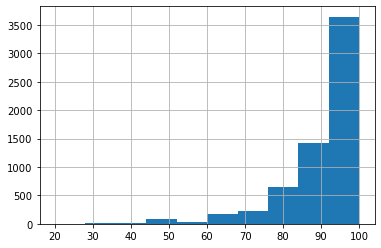

In [4]:
df.RecommendationScore.hist()

In [5]:
# boxcox transformation
from scipy.stats import boxcox

y_t, _lambda = boxcox(df.RecommendationScore)

_lambda

6.158874621332958

Lambda: 6.884986592420364


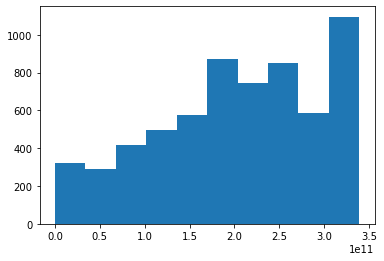

In [6]:
import scipy.stats as stats
lamb=stats.boxcox_normmax(df.RecommendationScore, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
score=(np.power(df.RecommendationScore,6.16)-1)/6.16

df['transformed_score'] = score
plt.hist(score);

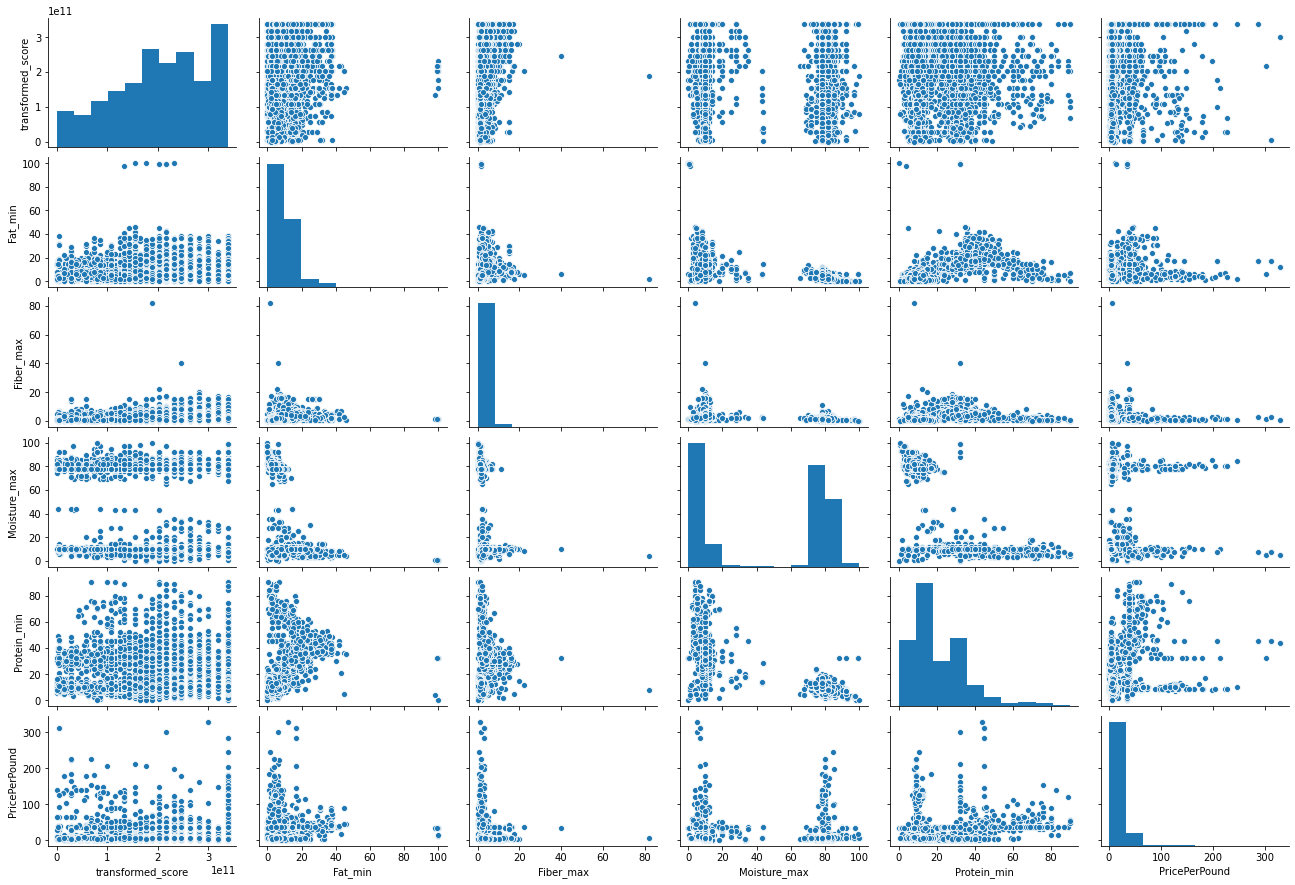

In [7]:
clean_plot = df[['transformed_score','Fat_min','Fiber_max','Moisture_max','Protein_min','PricePerPound']]
sns.pairplot(clean_plot, height=2, aspect=1.5);

## Linear regression with transformed score

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

y, X = patsy.dmatrices('transformed_score ~ Fat_min + Fiber_max + Moisture_max + Protein_min\
                       + PricePerPound + Treats + DryFood + WetFood\
                       + FreezeDried + FoodTopping + Dehydrated + AirDried + Frozen \
                       + Pet + BrandGroup_BrandGroup2 \
                       + BrandGroup_BrandGroup3 + BrandGroup_BrandGroup4', data=df, return_type="dataframe")

model = sm.OLS(y, X) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transformed_score   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     65.40
Date:                Sun, 11 Oct 2020   Prob (F-statistic):          5.57e-207
Time:                        14:38:43   Log-Likelihood:            -1.6643e+05
No. Observations:                6256   AIC:                         3.329e+05
Df Residuals:                    6238   BIC:                         3.330e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.427e+11   1.16e+10     20.956      0.000     2.2e+11    2.65e+11
Fat_min                -7.431e+07   2.15e+08     -0.345      0.730   -4.97e+08    3.48e+08
Fiber_max               4.732e+07   5.84e+08      0.081      0.935    -1.1e+09    1.19e+09
Moisture_max            1.427e+08   1.42e+08      1.004      0.316   -1.36e+08    4.21e+08
Protein_min             9.491e+08    1.8e+08      5.264      0.000    5.96e+08     1.3e+09
PricePerPound           5.683e+06   5.43e+07      0.105      0.917   -1.01e+08    1.12e+08
Treats                 -1.457e+10   6.28e+09     -2.320      0.020   -2.69e+10   -2.26e+09
DryFood                 4.913e+09   7.48e+09      0.657      0.512   -9.76e+09    1.96e+10
WetFood                -9.429e+09   8.83e+09     -1.068      0.286   -2.67e+10    7.88e+09
FreezeDried            -2.438e+10   7.03e+09     -3.466      0.001   -3.82e+10   -1.06e+10
FoodTopping            -6.954e+09    6.1e+09     -1.139      0.255   -1.89e+10    5.01e+09
Dehydrated             -6.803e+10   1.09e+10     -6.215      0.000   -8.95e+10   -4.66e+10
AirDried                5.149e+10   1.75e+10      2.950      0.003    1.73e+10    8.57e+10
Frozen                 -8.332e+10   2.16e+10     -3.866      0.000   -1.26e+11   -4.11e+10
Pet                    -6.125e+10   2.43e+09    -25.238      0.000    -6.6e+10   -5.65e+10
BrandGroup_BrandGroup2 -2.747e+10    3.3e+09     -8.332      0.000   -3.39e+10    -2.1e+10
BrandGroup_BrandGroup3 -3.742e+10   3.38e+09    -11.076      0.000    -4.4e+10   -3.08e+10
BrandGroup_BrandGroup4 -3.645e+10   3.31e+09    -11.017      0.000   -4.29e+10      -3e+10
==============================================================================
Omnibus:                       98.136   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.772
Skew:                          -0.118   Prob(JB):                     8.61e-15
Kurtosis:                       2.561   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model still has strong multicollinearity.

In [9]:
df.head()

,RecommendationScore,ReviewNum,Price,Protein_min,Fat_min,Moisture_max,Fiber_max,Pet,Weight,PricePerPound,...,WetFood,FreezeDried,FoodTopping,Dehydrated,AirDried,Frozen,BrandGroup_BrandGroup2,BrandGroup_BrandGroup3,BrandGroup_BrandGroup4,transformed_score
0,94.0,2676,42.99,32.0,14.0,10.0,5.0,0,24.0,1.791250,...,0,0,0,0,0,0,1,0,0,2.316791e+11
1,95.0,295,15.99,18.0,7.0,33.0,3.0,0,13.5,1.184444,...,0,0,0,0,0,0,0,0,1,2.472844e+11
2,96.0,854,32.98,26.0,15.0,10.0,4.0,0,15.0,2.198667,...,0,0,0,0,0,0,0,0,0,2.637607e+11
3,100.0,19,48.99,30.0,9.0,10.0,9.0,0,24.0,2.041250,...,0,0,0,0,0,0,1,0,0,3.391714e+11
4,95.0,3310,48.99,32.0,18.0,10.0,4.0,0,NaN,2.726818,...,0,0,0,0,0,0,0,0,1,2.472844e+11


## Use Sklearn

In [10]:
# Get predictors and target variable

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold

df_model = df.copy()
df_model.drop('ReviewNum',axis = 1, inplace = True)
df_model.drop('Weight',axis = 1, inplace = True)
df_model.drop('Price',axis = 1, inplace = True)
df_model.drop('RecommendationScore',axis = 1, inplace = True)


X, y = df_model.drop('transformed_score',axis=1), df_model['transformed_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [11]:
# standardization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [12]:
df_model.head(10)

,Protein_min,Fat_min,Moisture_max,Fiber_max,Pet,PricePerPound,Treats,DryFood,WetFood,FreezeDried,FoodTopping,Dehydrated,AirDried,Frozen,BrandGroup_BrandGroup2,BrandGroup_BrandGroup3,BrandGroup_BrandGroup4,transformed_score
0,32.0,14.0,10.0,5.0,0,1.791250,0,1,0,0,0,0,0,0,1,0,0,2.316791e+11
1,18.0,7.0,33.0,3.0,0,1.184444,0,1,0,0,0,0,0,0,0,0,1,2.472844e+11
2,26.0,15.0,10.0,4.0,0,2.198667,0,1,0,0,0,0,0,0,0,0,0,2.637607e+11
3,30.0,9.0,10.0,9.0,0,2.041250,0,1,0,0,0,0,0,0,1,0,0,3.391714e+11
4,32.0,18.0,10.0,4.0,0,2.726818,0,1,0,0,0,0,0,0,0,0,1,2.472844e+11
5,24.0,13.0,12.0,5.0,0,0.999750,0,1,0,0,0,0,0,0,0,0,1,2.029328e+11
6,24.0,14.0,10.0,5.0,0,1.666000,0,1,0,0,0,0,0,0,0,0,0,2.637607e+11
7,21.0,10.0,12.0,4.0,0,0.661515,0,1,0,0,0,0,0,0,0,1,0,2.472844e+11
8,26.0,14.0,10.0,4.0,0,1.099750,0,1,0,0,0,0,0,0,1,0,0,2.169073e+11
9,32.0,32.0,10.0,3.0,0,2.189545,0,1,0,0,0,0,0,0,0,0,1,3.391714e+11


## Linear regression

In [13]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

print(np.mean(cross_val_score(lm, X_tr, y_train, cv=5, scoring='r2')))
lm.fit(X_tr, y_train)
print(f'Linear Regression test R^2: {lm.score(X_te, y_test):.3f}')

0.1433078412741894
Linear Regression test R^2: 0.146


In [14]:
df_model.describe()

,Protein_min,Fat_min,Moisture_max,Fiber_max,Pet,PricePerPound,Treats,DryFood,WetFood,FreezeDried,FoodTopping,Dehydrated,AirDried,Frozen,BrandGroup_BrandGroup2,BrandGroup_BrandGroup3,BrandGroup_BrandGroup4,transformed_score
count,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6.256000e+03
mean,20.072817,9.118925,47.743429,2.699948,0.419757,11.486993,0.063939,0.338875,0.518223,0.084239,0.073689,0.016784,0.004636,0.003037,0.265026,0.241528,0.284687,2.078281e+11
std,14.674983,7.836158,35.286139,2.487630,0.493559,23.917650,0.244663,0.473365,0.499708,0.277768,0.261285,0.128471,0.067932,0.055030,0.441382,0.428044,0.451301,9.399034e+10
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.459800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.677892e+07
25%,9.000000,4.000000,10.000000,1.000000,0.000000,2.954091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.438328e+11
50%,12.000000,6.500000,78.000000,1.500000,0.000000,5.156923,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.169073e+11
75%,28.500000,14.000000,80.000000,4.000000,1.000000,6.597818,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.811468e+11
max,90.000000,99.900000,100.000000,82.000000,1.000000,328.754717,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.391714e+11


## Lasso regression

We standardize the data before regularization

In [15]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [16]:
lasso_model.alpha_

100.0

In [17]:
lasso_model = Lasso(alpha = 100)
cross_val_score(lasso_model, X_tr, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')

array([0.13317319, 0.14398017, 0.12908574, 0.16071587, 0.14958424])

In [18]:
print(np.mean(cross_val_score(lasso_model, X_tr, y_train, cv=5, scoring='r2')))
lasso_model.fit(X_tr, y_train)
print(f'Lasso Regression test R^2: {lasso_model.score(X_te, y_test):.3f}')

0.14330784149437398
Lasso Regression test R^2: 0.146


In [19]:
lasso_coef = pd.DataFrame(zip(X_train.columns, lasso_model.coef_),columns=["feature","coef"])
lasso_coef

,feature,coef
0,Protein_min,1.701380e+10
1,Fat_min,-5.672210e+08
2,Moisture_max,7.739540e+09
3,Fiber_max,-8.583089e+08
4,Pet,-2.983468e+10
5,PricePerPound,-1.397541e+09
6,Treats,-4.099422e+09
7,DryFood,-6.749545e+08
8,WetFood,-9.256411e+09
9,FreezeDried,-9.234934e+09


## Ridge regression

In [20]:
ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [21]:
ridge_model.alpha_

30.01835813575589

In [22]:
ridge_model = Ridge(alpha = 72.3)
cross_val_score(ridge_model, X_tr, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')

array([0.13359647, 0.1438139 , 0.12998854, 0.16087234, 0.14816571])

In [23]:
print(np.mean(cross_val_score(ridge_model, X_tr, y_train, cv=5, scoring='r2')))
ridge_model.fit(X_tr, y_train)
print(f'Ridge Regression test R^2: {ridge_model.score(X_te, y_test):.4f}')

0.14328739173023525
Ridge Regression test R^2: 0.1476


In [24]:
lasso_coef = pd.DataFrame(zip(X_train.columns, ridge_model.coef_),columns=["feature","coef"])
lasso_coef

,feature,coef
0,Protein_min,1.472032e+10
1,Fat_min,-9.151399e+08
2,Moisture_max,4.213796e+09
3,Fiber_max,-1.044551e+09
4,Pet,-2.913305e+10
5,PricePerPound,-1.322712e+09
6,Treats,-3.547308e+09
7,DryFood,4.632294e+08
8,WetFood,-6.574368e+09
9,FreezeDried,-8.326766e+09


## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators= 200, random_state = 42)

In [26]:
print(f'Random Forest cv score: {np.mean(cross_val_score(rf, X_tr, y_train,cv=5))}')

Random Forest cv score: 0.17756603071586105


In [27]:
rf.fit(X_tr, y_train)
print(f'Random Forest test score: {rf.score(X_te, y_test):.4f}')

Random Forest test score: 0.2119


In [28]:
importance = {'feature_names':X_train.columns, 'feature_importance':rf.feature_importances_}
importance_df = pd.DataFrame(importance)
importance_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

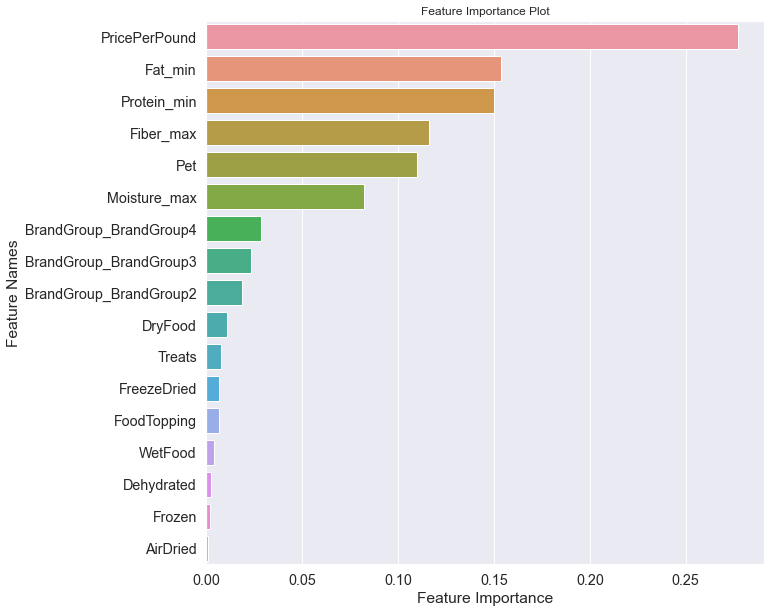

In [29]:
sns.set(font_scale=1.3)
plt.figure(figsize=(10,10))

with sns.color_palette("pastel"):
    sns.barplot(x=importance_df['feature_importance'], y=importance_df['feature_names']);
    sns.set(font = '20');

plt.title('Feature Importance Plot');
plt.xlabel('Feature Importance');
plt.ylabel('Feature Names');

## Visualizations with transformed data

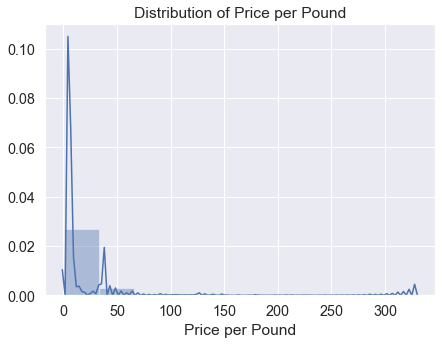

In [31]:
sns.set(font_scale=1.3)
plt.figure(figsize=(7,5))
sns.distplot(df_model['PricePerPound'],bins=10,norm_hist=True);
plt.xlabel('Price per Pound');
plt.title('Distribution of Price per Pound');

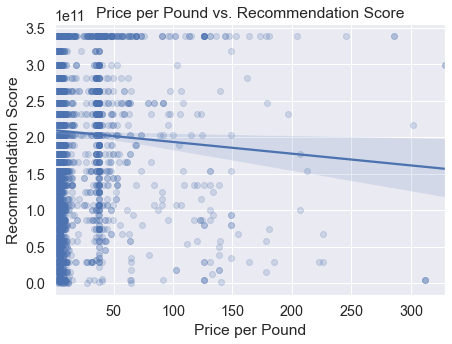

In [32]:
sns.set(font_scale=1.3)
plt.figure(figsize=(7,5))
sns.regplot(x="PricePerPound", y="transformed_score", data=df_model,scatter_kws={'alpha':0.2});
plt.xlabel('Price per Pound');
plt.ylabel('Recommendation Score');
plt.title('Price per Pound vs. Recommendation Score');

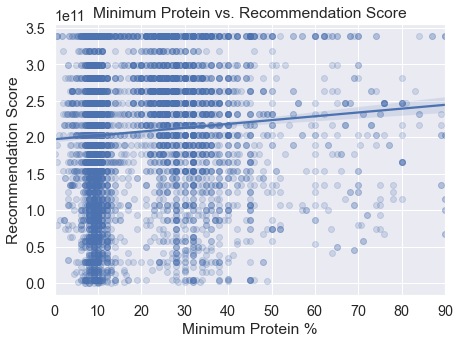

In [33]:
sns.set(font_scale=1.3)
plt.figure(figsize=(7,5))
sns.regplot(x="Protein_min", y="transformed_score", data=df_model,scatter_kws={'alpha':0.2});
plt.xlabel('Minimum Protein %');
plt.ylabel('Recommendation Score');
plt.title('Minimum Protein vs. Recommendation Score');

In [34]:
# for visualization purpose; create a new dataframe

df_clean_transform = df_clean.copy()


y_t, _lambda = boxcox(df_clean_transform.RecommendationScore)

_lambda

lamb=stats.boxcox_normmax(df_clean_transform.RecommendationScore, brack=(-1.9, 1.9)) 
print("Lambda:", lamb)
score=(np.power(df_clean_transform.RecommendationScore,6.16)-1)/6.16

df_clean_transform['transformed_score'] = score
df_clean_transform.columns

Lambda: 6.884986592420364


Index(['RecommendationScore', 'ReviewNum', 'ItemNumber', 'Price', 'Brand',
       'Protein_min', 'Fat_min', 'Moisture_max', 'Fiber_max', 'Pet', 'Weight',
       'PricePerPound', 'Adult', 'PuppyOrKitten', 'Senior', 'Treats',
       'DryFood', 'WetFood', 'FreezeDried', 'FoodTopping', 'Dehydrated',
       'AirDried', 'Frozen', 'BrandGroup', 'transformed_score'],
      dtype='object')

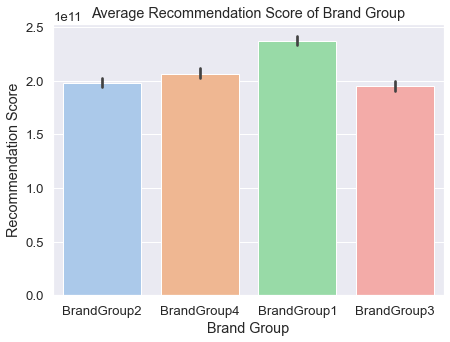

In [35]:
sns.set(font_scale=1.2)
plt.figure(figsize=(7,5))
with sns.color_palette("pastel"):
    score_brandgroup = df_clean_transform.groupby('BrandGroup')['transformed_score'].mean().reset_index()
    sns.barplot(x="BrandGroup", y="transformed_score", data=df_clean_transform)
plt.xlabel('Brand Group');
plt.ylabel('Recommendation Score');
plt.title('Average Recommendation Score of Brand Group');

In [36]:
food_type_dic = {
    'FoodType':['Treats','DryFood','WetFood','FreezeDried','FoodTopping','Dehydrated','AirDried','Frozen'],
    'Count': [df_model['Treats'].sum(),df_model['DryFood'].sum(),df_model['WetFood'].sum(),
    df_model['FreezeDried'].sum(),df_model['FoodTopping'].sum(),df_model['Dehydrated'].sum(),
    df_model['AirDried'].sum(),df_model['Frozen'].sum()]
}


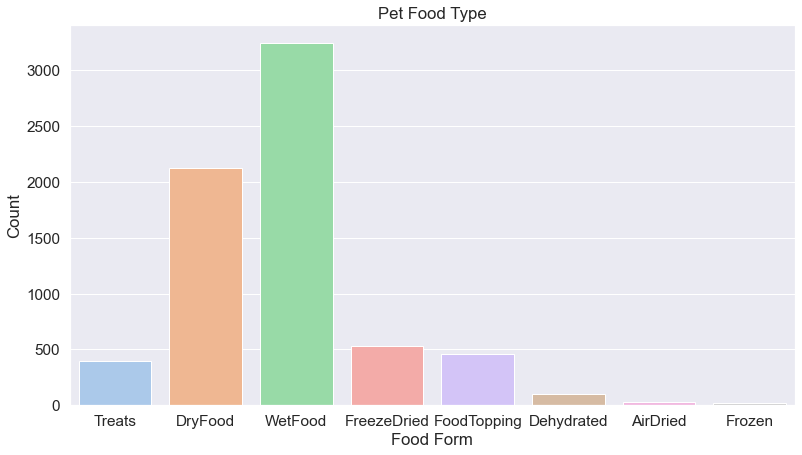

In [37]:
sns.set(font_scale=1.4)
plt.figure(figsize=(13,7))
with sns.color_palette("pastel"):
    sns.barplot(x='FoodType',y='Count',data=food_type_dic)
plt.xlabel('Food Form');
plt.ylabel('Count');
plt.title('Pet Food Type');

# Drop more least important features from the feature importance plot
Dropping features would decrease performance but reduce multicollinearity 

## Linear regression (statsmodel)

In [38]:
y_exp, X_exp = patsy.dmatrices('transformed_score ~ Fat_min + Fiber_max + Moisture_max + Protein_min\
                       + PricePerPound + Treats + DryFood \
                        + FoodTopping \
                       + Pet + BrandGroup_BrandGroup2 \
                       + BrandGroup_BrandGroup3 + BrandGroup_BrandGroup4', data=df, return_type="dataframe")

model_exp = sm.OLS(y_exp, X_exp) 
fit = model_exp.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transformed_score   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     87.29
Date:                Sun, 11 Oct 2020   Prob (F-statistic):          8.26e-200
Time:                        14:38:57   Log-Likelihood:            -1.6646e+05
No. Observations:                6256   AIC:                         3.329e+05
Df Residuals:                    6243   BIC:                         3.330e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.233e+11   1.09e+10     20.506      0.000    2.02e+11    2.45e+11
Fat_min                -3.244e+07    2.1e+08     -0.154      0.877   -4.45e+08     3.8e+08
Fiber_max              -1.228e+08   5.84e+08     -0.210      0.834   -1.27e+09    1.02e+09
Moisture_max            2.861e+08   1.14e+08      2.509      0.012    6.25e+07     5.1e+08
Protein_min             7.148e+08   1.68e+08      4.250      0.000    3.85e+08    1.04e+09
PricePerPound           3.389e+07    5.4e+07      0.627      0.531    -7.2e+07     1.4e+08
Treats                 -1.116e+10   6.19e+09     -1.802      0.072   -2.33e+10     9.8e+08
DryFood                 2.912e+10   5.09e+09      5.722      0.000    1.91e+10    3.91e+10
FoodTopping             1.241e+09   5.05e+09      0.246      0.806   -8.67e+09    1.11e+10
Pet                     -5.97e+10   2.42e+09    -24.645      0.000   -6.44e+10    -5.5e+10
BrandGroup_BrandGroup2 -2.879e+10    3.3e+09     -8.731      0.000   -3.53e+10   -2.23e+10
BrandGroup_BrandGroup3  -3.93e+10   3.38e+09    -11.635      0.000   -4.59e+10   -3.27e+10
BrandGroup_BrandGroup4 -3.619e+10   3.32e+09    -10.902      0.000   -4.27e+10   -2.97e+10
==============================================================================
Omnibus:                      116.903   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.796
Skew:                          -0.117   Prob(JB):                     1.56e-16
Kurtosis:                       2.526   Cond. No.                         644.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
df_exp = df_model.copy()
# df_exp.drop('DryFood',axis = 1, inplace = True)
df_exp.drop('WetFood',axis = 1, inplace = True)
# df_exp.drop('FoodTopping',axis = 1, inplace = True)
# df_exp.drop('Treats',axis = 1, inplace = True)
df_exp.drop('FreezeDried',axis = 1, inplace = True)
df_exp.drop('AirDried',axis = 1, inplace = True)
df_exp.drop('Dehydrated',axis = 1, inplace = True)
df_exp.drop('Frozen',axis = 1, inplace = True)


X_exp, y_exp = df_exp.drop('transformed_score',axis=1), df_exp['transformed_score']
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, test_size=.2, random_state=42)

In [40]:
df_exp.describe()

,Protein_min,Fat_min,Moisture_max,Fiber_max,Pet,PricePerPound,Treats,DryFood,FoodTopping,BrandGroup_BrandGroup2,BrandGroup_BrandGroup3,BrandGroup_BrandGroup4,transformed_score
count,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6.256000e+03
mean,20.072817,9.118925,47.743429,2.699948,0.419757,11.486993,0.063939,0.338875,0.073689,0.265026,0.241528,0.284687,2.078281e+11
std,14.674983,7.836158,35.286139,2.487630,0.493559,23.917650,0.244663,0.473365,0.261285,0.441382,0.428044,0.451301,9.399034e+10
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.459800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.677892e+07
25%,9.000000,4.000000,10.000000,1.000000,0.000000,2.954091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.438328e+11
50%,12.000000,6.500000,78.000000,1.500000,0.000000,5.156923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.169073e+11
75%,28.500000,14.000000,80.000000,4.000000,1.000000,6.597818,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.811468e+11
max,90.000000,99.900000,100.000000,82.000000,1.000000,328.754717,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.391714e+11


In [41]:
std_exp = StandardScaler()
std_exp.fit(X_train_exp)
X_tr_exp = std_exp.transform(X_train_exp.values)
X_te_exp = std_exp.transform(X_test_exp.values)

### Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
rf_exp = RandomForestRegressor(n_estimators=200,random_state = 42)

print(f'Random Forest cv score: {np.mean(cross_val_score(rf_exp, X_tr_exp, y_train_exp,cv=5))}')

rf_exp.fit(X_tr_exp, y_train_exp)
print(f'Random Forest test score: {rf_exp.score(X_te_exp, y_test_exp):.4f}')

Random Forest cv score: 0.17670541894734834
Random Forest test score: 0.2144


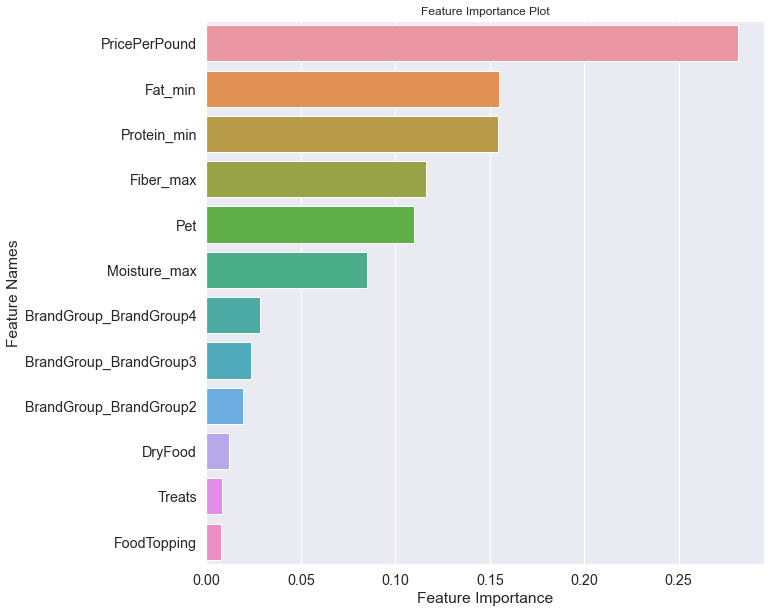

In [43]:
importance_exp = {'feature_names':X_train_exp.columns, 'feature_importance':rf_exp.feature_importances_}
importance_df_exp = pd.DataFrame(importance_exp)
importance_df_exp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
sns.set(font_scale=1.3)
plt.figure(figsize=(10,10))

with sns.color_palette("pastel"):
    sns.barplot(x=importance_df_exp['feature_importance'], y=importance_df_exp['feature_names']);
    sns.set(font = '20');

plt.title('Feature Importance Plot');
plt.xlabel('Feature Importance');
plt.ylabel('Feature Names');

### Ridge Regression

In [44]:
ridge_model_exp = RidgeCV(alphas = alphavec, cv=5)
ridge_model_exp.fit(X_tr_exp, y_train_exp)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [45]:
ridge_model_exp.alpha_

26.126752255633292

In [46]:
ridge_model_exp = Ridge(alpha = 13.667)
cross_val_score(ridge_model_exp, X_tr_exp, y_train_exp, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')

array([0.13636084, 0.13487742, 0.12160652, 0.15141093, 0.13808833])

In [47]:
print(np.mean(cross_val_score(ridge_model_exp, X_tr_exp, y_train_exp, cv=5, scoring='r2')))
ridge_model_exp.fit(X_tr_exp, y_train_exp)
print(f'Ridge Regression test R^2: {ridge_model_exp.score(X_te_exp, y_test_exp):.4f}')

0.13646880767043204
Ridge Regression test R^2: 0.1444


In [48]:
ridge_coef_exp = pd.DataFrame(zip(X_train_exp.columns, ridge_model_exp.coef_),columns=["feature","coef"])
ridge_coef_exp

,feature,coef
0,Protein_min,1.195895e+10
1,Fat_min,-8.415927e+08
2,Moisture_max,9.963706e+09
3,Fiber_max,-1.439586e+09
4,Pet,-2.893410e+10
5,PricePerPound,-8.081643e+08
6,Treats,-2.689760e+09
7,DryFood,1.362663e+10
8,FoodTopping,5.439144e+08
9,BrandGroup_BrandGroup2,-1.375320e+10


### Lasso Regression

In [49]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model_exp = LassoCV(alphas = alphavec, cv=5)
lasso_model_exp.fit(X_tr_exp, y_train_exp)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [50]:
lasso_model_exp.alpha_

100.0

In [51]:
lasso_model_exp = Lasso(alpha = 100)
cross_val_score(lasso_model_exp, X_tr_exp, y_train_exp, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')

array([0.13634625, 0.13478476, 0.12124399, 0.15144987, 0.13831821])

In [52]:
print(np.mean(cross_val_score(lasso_model_exp, X_tr_exp, y_train_exp, cv=5, scoring='r2')))
lasso_model_exp.fit(X_tr_exp, y_train_exp)
print(f'Lasso Regression test R^2: {lasso_model_exp.score(X_te_exp, y_test_exp):.3f}')

0.13642861643742005
Lasso Regression test R^2: 0.144


In [53]:
lasso_coef_exp = pd.DataFrame(zip(X_train_exp.columns, lasso_model_exp.coef_),columns=["feature","coef"])
lasso_coef_exp

,feature,coef
0,Protein_min,1.241690e+10
1,Fat_min,-7.264102e+08
2,Moisture_max,1.078740e+10
3,Fiber_max,-1.389065e+09
4,Pet,-2.908074e+10
5,PricePerPound,-7.692434e+08
6,Treats,-2.716505e+09
7,DryFood,1.398579e+10
8,FoodTopping,6.013315e+08
9,BrandGroup_BrandGroup2,-1.392517e+10


### Linear Regression

In [54]:
lm_exp = LinearRegression()

print(np.mean(cross_val_score(lm_exp, X_tr_exp, y_train_exp, cv=5, scoring='r2')))
lm_exp.fit(X_tr_exp, y_train_exp)
print(f'Linear Regression test R^2: {lm_exp.score(X_te_exp, y_test_exp):.3f}')

0.13642861623657784
Linear Regression test R^2: 0.144
